파이썬 딥러닝 텐서플로 ch4. 1-3 pg.142-181

---

# 04. 합성곱 신경망(CNN)

## 01. 합성곱 신경망

합성곱 신경망(CNN) : 데이터가 가진 특징들의 패턴을 학습하는 알고리즘

- 대표적으로 이미지 분류, 객체 탐지, 스타일 전이 등

### 1-1 이미지 표현

이미지(또는 영상)를 컴퓨터가 이해할 수 있게 하려면 숫자로 표현해야 한다

-> 0~255 사이의 숫자로 각 픽셀의 화소 값 나타내는 방식
- 화소 나타내는 숫자는 이미지의 강도. 숫자 클수록 더 강한 특성 나타낸다
  - 숫자 0 - 검은색, 숫자 255 - 흰색
- 컬러 이미지는 R(빨강), G(초록), B(파랑) 채널로 구성된 3장의 이미지 겹쳐서 표현.
  - 각 채널 이미지는 0~255 사이의 숫자로 나타냄

### 1-2 합성곱(Convolution)

합성곱 연산 : 입력 이미지에 대하여 일반적으로 정방형 크기를 가지는 커널을 사용하여, 입력 이미지에 대한 특성을 추출하는 방법

- 합성곱 연산을 통해서 추출된 이미지 = 특성맵
    - 특성맵을 딥러닝 모델 학습에 사용하면 훨씬 좋은 성능을 보인다.

- 입력 이미지의 일부분에 커널이 겹치도록 투영 -> 이미지와 커널이 겹치는 부분에 대하여  합성곱 연산 수행 -> 합성곱 연산은 element-wise 곱셈 연산을 수행 후 모두 더한 값으로 단일 스칼라 값이 나온다
    - 커널 = 필터

- 커널 사이즈가 3x3인 경우 총 9개의 가중치(weight).
- 오차 역전파 시 커널의 가중치 업데이트
    - 완전 연결층 사용할 때보다 연산량이 훨씬 적다는 장점 (공유 가중치)

### 1-3 채널(channel)

채널 : 입력 이미지를 구성하는 2차원 배열의 개수

- 흑백 이미지는 채널의 개수가 1개인 이미지 = 단 일채널
- 컬러 이미지는 R,G,B 3개의 채널 가지는 이미지
  - 세로 5픽셀, 가로 5픽셀의 컬러 이미지 shape => (5,5,3)

- 특성맵의 생성 과정

입력 이미지의 채널 개수만큼 커널 생성 -> 각 채널마다 하나씩 커널 적용해 합성곱 연산 수행(입력 이미지의 채널 개수만큼 생성) -> element-wise 덧셈 연산으로 모두 더해 최종 특성맵 생성

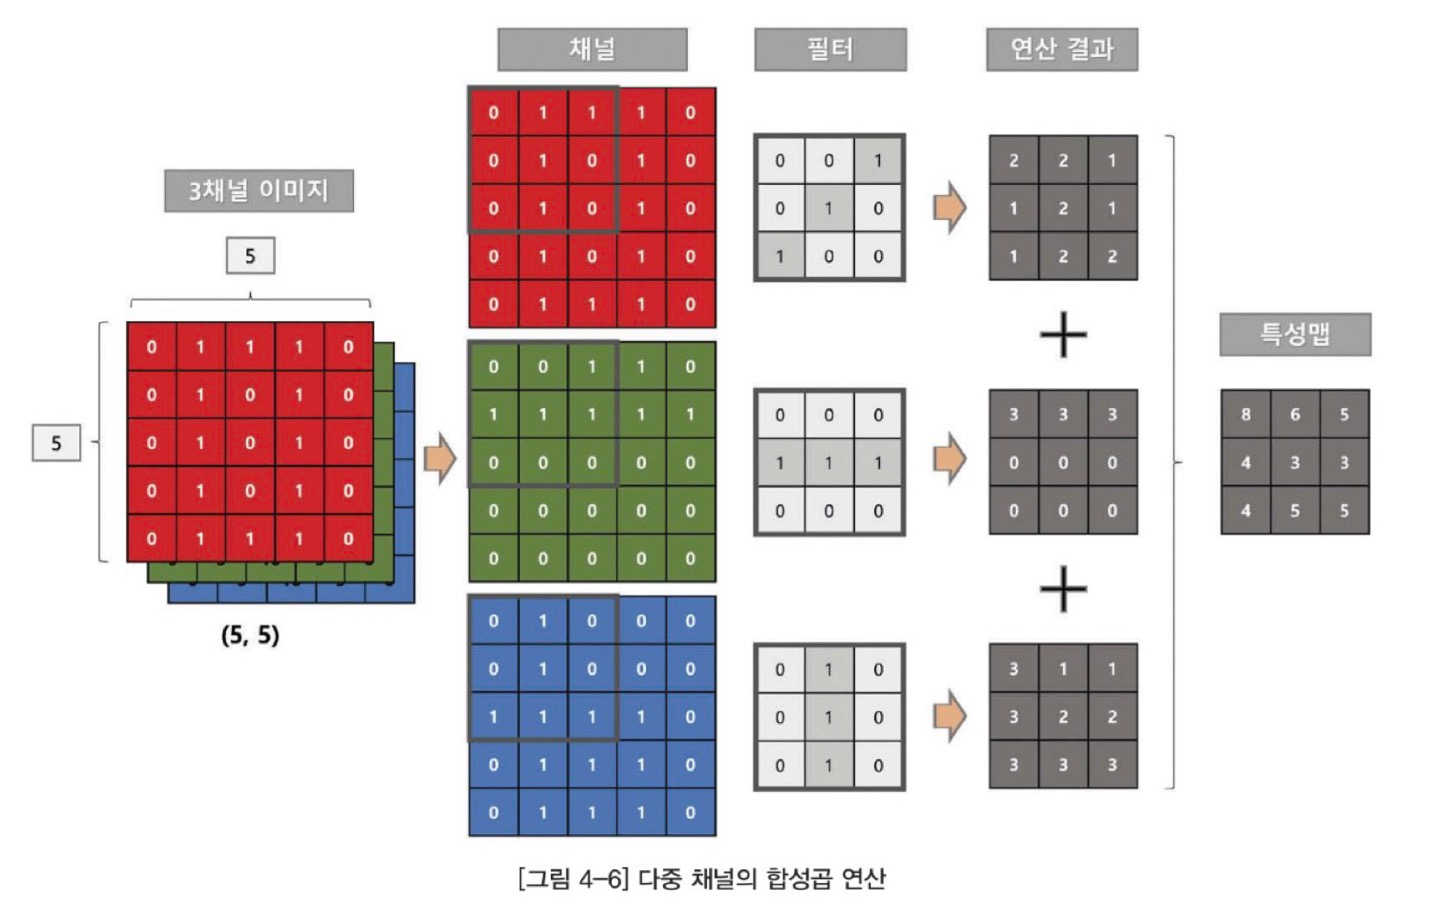

- 업데이트될 파라미터의 개수 = 1개 커널의 사이즈 x 입력 채널 수 x 출력 필터 수 + bias
- bias : 출력 필터 개수만큼 추가

### 1-4 스트라이드(stride)

커널은 좌측 상단부터 입력 이미지 기준으로 우측으로 이동하면서 합성곱 연산을 수행하며 특성맵에 결과를 채워나간다,
- 이때 이동하는 간격 : 스트라이드(stride)

- 주로 1 또는 2로 설정
  - 2로 설정하면 특성맵의 크기가 1/2로 줄어들게 된다

* 케라스에서 제공하는 Conv2D 레이어의 strides 매개변수에 스트라이드 지정

### 1-5 패딩(padding)

추출된 특성맵의 크기가 입력 이미지 대비 줄어들지 않도록 패딩(padding) 설정

- 일반적으로 zero-padding 사용 : 입력 이미지의 가장 자리에 0으로 채워진 패딩 값으로 채운 후 추출 -> 특성맵 크기 줄어들지 않는다

- 케라스의 Conv2D 레이어에서 padding='same'로 설정하면 zero-padding 적용. 기본값은 padding='valid'

### 1-6 특성맵(feature map) 사이즈

**(Output Height, Output Width) = ( (Image Height + 2P - Kernel Height) / S + 1, (Image Width + 2P - Kernel Width) / S + 1 )**

* Image Height, Image Width : 입력 크기(input size)
* Kernel Height, Kernel Width : 필터 크기(kernel size)
* S : 스트라이드(strides)
* P : 패딩(padding)
* Output Height, Output Width : 출력 크기(output size)

### 1-7 풀링(pooling)

풀링(pooling) 레이어 : 추출된 특성맵에 대해 다운 샘플링하여 이미지의 크기를 축소하는 레이어

- 이점 : 이미지 축소를 통해 연산량 감소, 과대적합 방지

- 최대 풀링(max pooling)과 평균 풀링(average pooling)
  + ex 최대 풀링의 커널 크기를 2x2로 설정. 스트라이드 2로 설정 -> 입력 이미지 대비 총 1/4 크기로 줄어든다

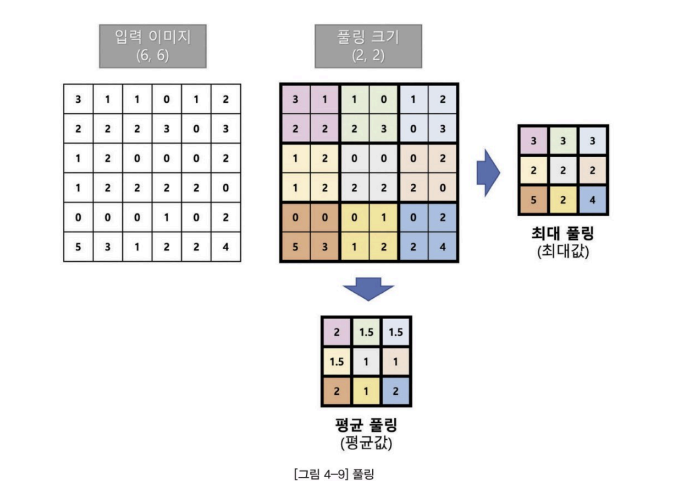

## 02. 간단한 모델 생성

mnist 손글씨 데이터셋 가지고 간단한 구조의 합성곱 신경망 모델

### 2-1 데이터 로드 및 전처리

In [1]:
# tensorflow 모듈 import
import tensorflow as tf

* 데이터셋 불러오면 훈련 셋과 검증 셋으로 구분해 투플 형태로 정리
  + 훈련 셋의 개수는 60,000개, 검증 셋의 개수는 10,000개
  + 가로, 세로 각각 28픽셀인 손글씨 이미지와 손글씨가 나타내는 숫자 레이블(정답)이 매칭되어 있다

In [2]:
# mnist 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_valid, y_valid)=mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


훈련 셋의 첫 번째 이미지 출력

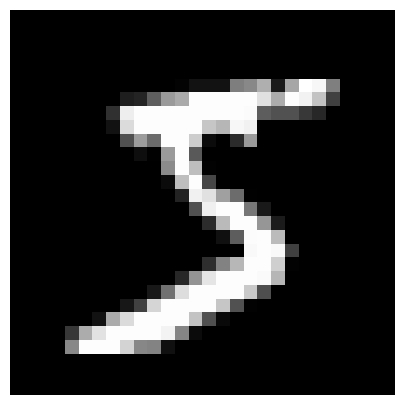

In [3]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx], cmap='gray')
  plt.axis('off')
  plt.show()

plot_image(x_train, 0)

픽셀의 최소값, 최대값 출력 -> 이미지 픽셀이 0~255 범위의 숫자로 구성됨

In [4]:
print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0 255
0 255


입력 이미지 픽셀 값을 정규화 변환 -> 최대값 255로 나누어 0~1 범위로 스케일 정규화

In [5]:
# 정규화(Normalization)
x_train = x_train/255.0
x_valid=x_valid/255.0

print(x_train.min(), x_train.max())
print(x_valid.min(), x_valid.max())

0.0 1.0
0.0 1.0


* mnist 데이터셋은 색상 나타내는 채널 1개인 모노 컬러 이미지로 구성 -> CNN 모델에 주입하기 위해 색상 나타내는 채널 추가

* [] 안에서 채널을 추가하고자 하는 위치에 **tf.newaxis** 작성
  + 가장 마지막 축에 채널 추가하기 위해 [..., tf.newaxis]
  + (60000, 28, 28) -> (60000, 28, 28, 1)

In [6]:
# 채널 추가
print(x_train.shape, x_valid.shape)

x_train_in = x_train[..., tf.newaxis]
x_valid_in = x_valid[..., tf.newaxis]

print(x_train.shape, x_valid.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28) (10000, 28, 28)


### 2-2 Sequential API로 모델 생성 및 학습


* Sequential API 사용하여 합성곱 레이어 1개, 풀링 레이어 1개를 적용하는 간단한 모델 생성

In [7]:
# Sequential API를 사용해 샘플 모델 생성
model=tf.keras.Sequential([
    #Convolution 적용 (32 filters)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', # (3,3) 크기의 서로 다른 32가지 종류 커널
                           input_shape=(28, 28, 1), name='conv'),
    #max pooling 적용
    tf.keras.layers.MaxPooling2D((2,2), name='pool'),
    #classifier 출력층
    tf.keras.layers.Flatten(),    # 1차원 배열로 펼쳐준다
    tf.keras.layers.Dense(10, activation='softmax')   # 다중 분류 문제
])

* 앞 모델 구조에 옵티마이저, 손실함수, 평가지표 설정해 주고 컴파일하면 모델 인스턴스 생성

In [8]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 46s 23ms/step - loss: 0.2121 - accuracy: 0.9395 - val_loss: 0.0893 - val_accuracy: 0.9745
Epoch 2/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0786 - accuracy: 0.9775 - val_loss: 0.0661 - val_accuracy: 0.9791
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0598 - accuracy: 0.9823 - val_loss: 0.0594 - val_accuracy: 0.9811
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0497 - accuracy: 0.9854 - val_loss: 0.0515 - val_accuracy: 0.9838
Epoch 5/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0406 - accuracy: 0.9876 - val_loss: 0.0518 - val_accuracy: 0.9828
Epoch 6/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0356 - accuracy: 0.9891 - val_loss: 0.0517 - val_accuracy: 0.9833
Epoch 7/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0296 - accuracy: 0.9911 - val_loss: 0.0513 -

* 모델의 학습된 가중치 사용하여 손실과 평가지표 계산

In [9]:
model.evaluate(x_valid_in, y_valid)

313/313 [==============================] - 2s 5ms/step - loss: 0.0583 - accuracy: 0.9834


[0.0582573376595974, 0.9833999872207642]

* 10 epoch 동안 모델의 예측 오차와 정확도를 그래프로 그리는 함수 정의하고 실행
  + 훈련 결과를 history 객체에 저장

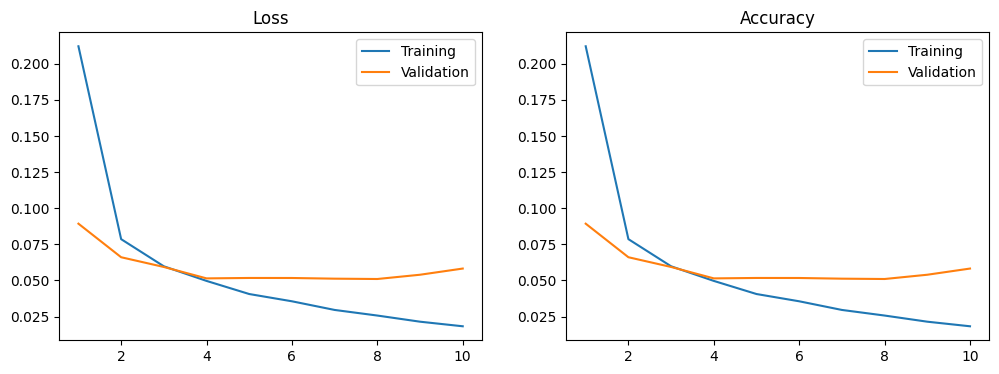

In [10]:
def plot_loss_acc(history, epoch):
  loss, val_loss=history.history['loss'], history.history['val_loss']
  acc, val_acc=history.history['accuracy'], history.history['val_accuracy']

  fig, axes=plt.subplots(1, 2, figsize=(12, 4))

  axes[0].plot(range(1, epoch+1), loss, label='Training')
  axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch+1), loss, label='Training')
  axes[1].plot(range(1, epoch+1), val_loss, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

plot_loss_acc(history, 10)

=> 검증 셋의 손실은 어느 수준에서 더 이상 낮아지지 않는다. 4 epoch 이후부터는 모델이 과대적합으로 진행되었다

### 2-3 모델 구조 파악

* (28, 28, 1) 형태의 입력 텐서가 Conv2D 거치면서 (26, 26, 32) 형태로 변환
  + (3,3) 크기의 합성곱 필터 사용해서 이미지 가로, 세로 크기 2씩 줄어든다
  + 서로 다른 32개의 필터 적용해 특성맵 32개 생성
  + (2,2) 크기의 풀링 레이어 적용해 이미지 크기 1/2로 줄어든다 (13,13,32) 텐서로 변환
  + Flatten 층에서 1차원 텐서로 펼쳐 13x13x32원소 갖는 1차원 벡터

In [11]:
# 모델 구조
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* 생성된 모델 인스턴스의 **input** 속성으로부터 입력 레이어의 텐서 추출 (None, 28, 28, 1) 형태
  + 가장 앞에 있는 축(axis=0)의 None값 : 배치 크기가 들어오는 위치로서 배치 크기로 어떤 값이든 가능하다

In [12]:
# 입력 텐서 형태
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

* 모델의 출력 텐서는 **output** 속성으로 선택

In [13]:
# 출력 텐서 형태
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

=> 10개 노드 갖는 1차원 벡터 형태

* 모델을 구성하는 레이어들을 추출하려면 **layers** 속성 확인
  + 파이썬 리스트 형태로 레이어 객체 담아서 보여준다

In [14]:
# 레이어
model.layers

* 4개의 레이어로 구성된 모델 작성. 첫 번째 레이어 선택

In [15]:
# 첫 번째 레이어 선택
model.layers[0]

* 각 레이어에 입력되는 텐서를 따로 선택하는 것도 가능
  + 앞 Conv2D 레이어는 입력 데이터 그대로 들어가 (None, 28,28,1) 형태

In [16]:
# 첫 번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

* 각 레이어에 출력되는 텐서도 확인 가능
  + Conv2D 레이어 거치면서 픽셀 사이즈 2씩 줄어들고 채널 개수가 32개로 늘어나 (None, 26,26,32) 형태

In [17]:
# 첫 번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

* 각 레이어의 가중치 행렬 추출 가능 **weights**속성을 각 레이어 인스턴스에 적용

In [18]:
# 첫 번째 레이어 가중치
model.layers[0].weights

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.33479753,  0.42260113, -0.04184708,  0.2579077 ,
           -0.46966285, -0.3321323 , -0.0321294 ,  0.3496884 ,
           -0.3252468 ,  0.15627673,  0.37269115,  0.13962774,
            0.14439774, -0.41134748,  0.08302826,  0.33995298,
            0.02192085, -0.70565087, -0.48476073, -0.9182056 ,
           -0.54820246,  0.39323017, -0.27859777, -1.2376124 ,
           -0.7675426 ,  0.25251487,  0.19722722, -0.20066094,
           -0.7220193 , -0.10873957, -0.2998308 ,  0.3917904 ]],
 
         [[ 0.10124609, -0.16212676, -0.40108585,  0.2084251 ,
           -0.12316508, -0.09275289,  0.6735236 ,  0.03822846,
            0.3407578 ,  0.4299725 ,  0.48772714,  0.34715214,
            0.1427805 , -0.20162056, -0.62863415,  0.28887954,
            0.35163283, -0.00820414,  0.04852345, -0.2891711 ,
            0.00478751,  0.7208909 , -0.98052806, -0.11010801,
           -0.19029443,  0.25591215,  0.19

=>
>* tf.Variable : 가중치와 같이 모델 학습 과정에 값이 업데이트되는 경우 사용한다
>* 첫 번째 변수는 'conv/kernel:0' -> 커널(합성곱 필터) 행렬의 가중치
>* 두 번째 변수는 'conv/bias:0' -> 각 커널의 상수항(bias)
>* 커널 가중치의 shape = (3, 3, 1, 32). (3,3)은 필터의 크기, (1)은 입력층의 채널 개수, (32)는 출력층의 채널 개수
>* 상수항(bias) 가중치의 shape = (32, )이고 출력층의 채널 수
>* layer[0]의 총 학습 가능한 파라미터 수 = 커널(3x3x1x32) + 상수항(32) = 320개

* 커널 행렬의 가중치 또는 상수항 따로 선택 가능

In [19]:
# 첫 번째 레이어 커널 가중치
model.layers[0].kernel

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-0.33479753,  0.42260113, -0.04184708,  0.2579077 ,
          -0.46966285, -0.3321323 , -0.0321294 ,  0.3496884 ,
          -0.3252468 ,  0.15627673,  0.37269115,  0.13962774,
           0.14439774, -0.41134748,  0.08302826,  0.33995298,
           0.02192085, -0.70565087, -0.48476073, -0.9182056 ,
          -0.54820246,  0.39323017, -0.27859777, -1.2376124 ,
          -0.7675426 ,  0.25251487,  0.19722722, -0.20066094,
          -0.7220193 , -0.10873957, -0.2998308 ,  0.3917904 ]],

        [[ 0.10124609, -0.16212676, -0.40108585,  0.2084251 ,
          -0.12316508, -0.09275289,  0.6735236 ,  0.03822846,
           0.3407578 ,  0.4299725 ,  0.48772714,  0.34715214,
           0.1427805 , -0.20162056, -0.62863415,  0.28887954,
           0.35163283, -0.00820414,  0.04852345, -0.2891711 ,
           0.00478751,  0.7208909 , -0.98052806, -0.11010801,
          -0.19029443,  0.25591215,  0.19485047,  0.289418

In [20]:
# 첫 번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.1938198 , -0.46602178, -0.1714319 , -0.33462122, -0.21969253,
       -0.10076568, -0.01554132, -0.30144566, -0.20230429, -0.15137663,
       -0.01437868, -0.19933619, -0.27580616, -0.01421238, -0.21936353,
       -0.07874747, -0.0730171 , -0.09585878, -0.22353213, -0.05756068,
       -0.15256368, -0.01293773, -0.02777776,  0.20908248, -0.13406019,
       -0.37256756, -0.33455473, -0.12723182, -0.00750833,  0.03872787,
       -0.26156515, -0.41570786], dtype=float32)>

* 레이어 이름(name 속성) 사용하여 해당 레이어 선택 가능

In [21]:
# 레이어 이름 사용해 레이어 선택
model.get_layer('conv')

* 모델에 입력 데이터를 넣어주고, 모델의 첫 번째와 두 번째 레이어의 출력을 최종 출력으로 갖는 activator 모델 정의

In [22]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가 (첫 번째, 두 번째 레이어)
activator = tf.keras.Model(inputs=model.input,
                           outputs=[layer.output for layer in model.layers[:2]])
activations=activator.predict(x_train_in[0][tf.newaxis, ...])

len(activations)

1/1 [==============================] - 0s 123ms/step


2

* 2개의 출력 텐서 중에서 첫 번째 텐서는 Conv2D 레이어의 출력

In [23]:
# 첫 번재 레이어 conv의 출력층
conv_activation=activations[0]
conv_activation.shape

(1, 26, 26, 32)

=> 텐서의 형태는 (1,26,26,32). 여기서 1은 입력 이미지의 개수

* 첫 번째 레이어에서 출력되는 특성맵 이미지를 32개 커널별로 구분하여 시각화
  + 각 커널은 입력 이미지로부터 서로 다른 피처(특징)을 추출하는 역할

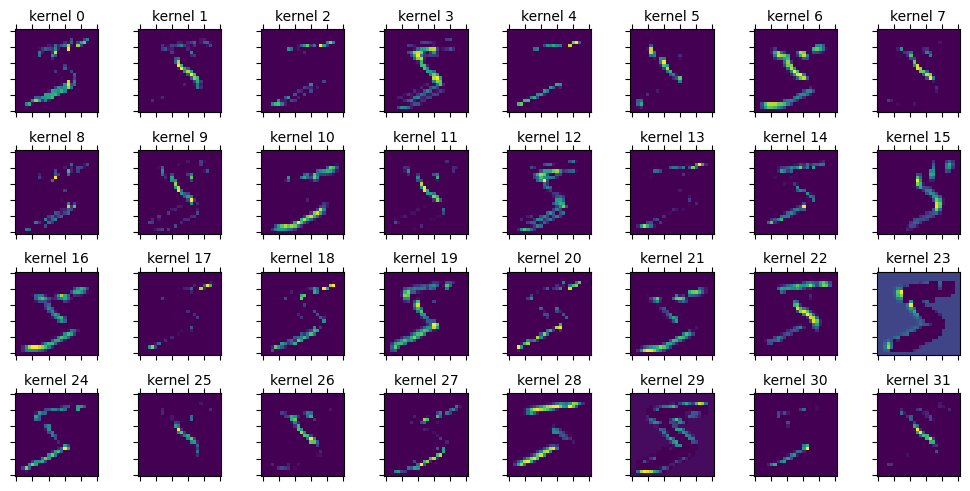

In [24]:
# Convolution 시각화
fig, axes=plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
  axes[i//8, i%8].matshow(conv_activation[0, :, :, i], cmap='viridis')
  axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
  plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
  plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

* 두 번째 레이어는 최대 풀링 레이어

In [25]:
# 두번째 레이어 pool 출력층
pooling_activation=activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


=> 출력하는 텐서는 (1,13,13,32) 형태

* 각 커널별로 출력되는 특성맵 이미지 시각화

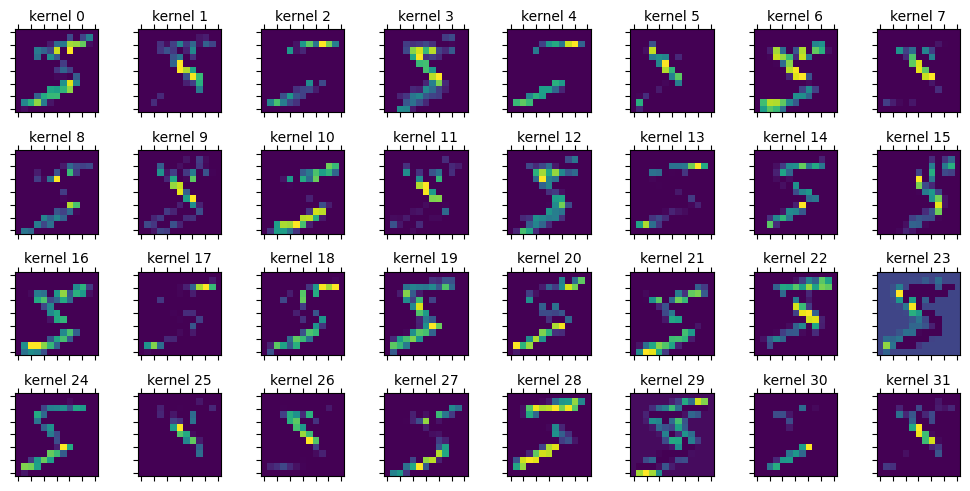

In [26]:
# 시각화
fig, axes=plt.subplots(4, 8)
fig.set_size_inches(10, 5)

for i in range(32):
  axes[i//8, i%8].matshow(pooling_activation[0, :, :, i], cmap='viridis')
  axes[i//8, i%8].set_title('kernel %s'%str(i), fontsize=10)
  plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
  plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

=> Conv2D 출력 이미지에 비하여 화소 크기가 굵어짐

최대 풀링은 인근 픽셀들을 모아서 최대값으로 고정 -> 픽셀 수는 줄이면서 특징을 더욱 강하게 드러낼 수 있다

## 03. 복잡한 모델 생성



---


텐서플로 케라스의 Functional API 사용하면, Sequential API로 구현할 수 없는 복잡한 구조의 모델 정의 가능

ex) 각 레이어를 기준으로 입력이 2개 이상이거나 출력이 2개 이상인 모델, 중간 레이어를 건너뛰고 뒤쪽에 있는 레이어로 출력 텐서를 전달하는 방식의 직접 연결.

### 3-1 데이터셋 준비

In [27]:
import tensorflow as tf
import numpy as np

In [28]:
#mnist 손글씨 이미지 데이터 로드
mnist=tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid)=mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


* 원본 정답 외에 홀수인지 짝수인지 판단하는 정답 (y_odd)를 추가
  + 원본 mnist 데이터셋은 0~9까지 숫자

In [29]:
# 새로운 출력 값 배열 생성 (홀수 : 1, 짝수 : 0)
y_train_odd=[]
for y in y_train:
  if y%2==0:
    y_train_odd.append(0)
  else:
    y_train_odd.append(1)

y_train_odd=np.array(y_train_odd)
y_train_odd.shape

(60000,)

* 원본 y_train 배열과 홀짝으로 분류한 y_train_odd 배열 동시에 출력해 비교

In [30]:
print(y_train[:10])
print(y_train_odd[:10])

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


* 검증 데이터셋에 대해서도 y_valid_odd 배열 만들기

In [31]:
# Validation 데이터셋 처리
y_valid_odd=[]
for y in y_valid:
  if y%2==0:
    y_valid_odd.append(0)
  else:
    y_valid_odd.append(1)

y_valid_odd=np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

* 입력 이미지 데이터를 255로 나눠서 정규화
  + 모노 컬러 이미지 -> 새로운 축 추가. 채널 개수 1개로 지정
  + expand_dims() 함수에서 축의 인덱스로 -1 지정하면 새로운 축은 끝에 추가
  + (60000, 28, 28) -> (60000, 28, 28, 1)

In [32]:
# 정규화
x_train=x_train/255.0
x_valid=x_valid/255.0

# 채널 추가
x_train_in=tf.expand_dims(x_train, -1)
x_valid_in=tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### 3-2 Functional API로 다중 입력, 다중 출력 레이어 생성

Functional API 사용하면 다중 입력 또는 다중 출력 같은 구조 만들 수 있다

다음 코드 > 입력 레이어 inputs의 경우, Conv2D 레이어와 Flatten 레이어의 입력으로 사용(2개의 출력) -> 각각 다른 레이어의 입력으로 사용. 최종적으로 Concatenate 레이어에서 합쳐져 Dense 레이어 통과

=> 함수의 입력과 출력으로 표현할 수 있어서 자유롭게 모델 구조 정의할 수 있는 장점

In [33]:
# Functional API 를 사용하여 모델 생성

inputs=tf.keras.layers.Input(shape=(28, 28, 1))

conv=tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
pool=tf.keras.layers.MaxPooling2D((2,2))(conv)
flat=tf.keras.layers.Flatten()(pool)

flat_inputs=tf.keras.layers.Flatten()(inputs)
concat=tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs=tf.keras.layers.Dense(10, activation='softmax')(concat)

model=tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 26, 26, 32)           320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 flatten_1 (Flatten)         (None, 5408)                 0         ['max_pooling2d[0][0]'] 

* 케라스 utils 모듈의 **plot_model** 함수 사용해 모델 입력하면 모델 구조 그래프로 출력 + 별도의 파일로도 저장 가능

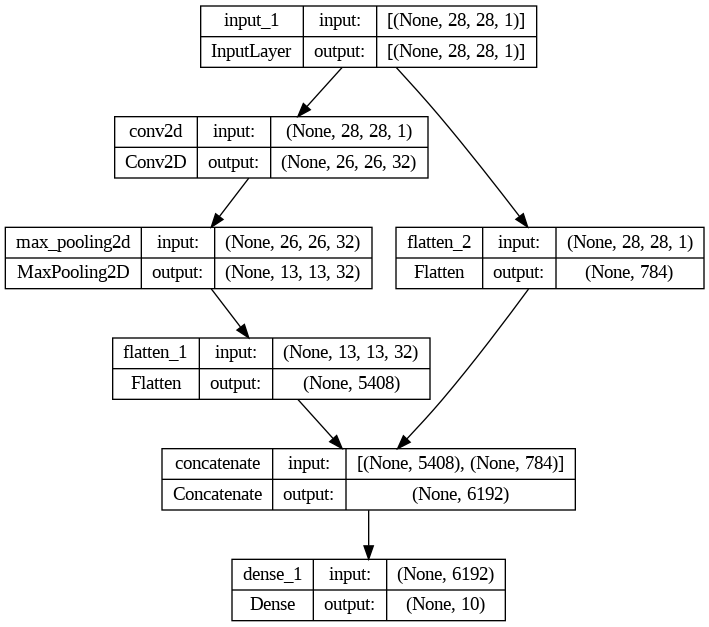

In [34]:
# 모델 구조 출력 및 이미지 파일로 저장
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

* 모델 컴파일, 훈련, 예측 성능 평가

In [35]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=model.fit(x_train_in, y_train, validation_data=(x_valid, y_valid), epochs=10)

# 모델 성능
val_loss, val_acc=model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1992 - accuracy: 0.9442 - val_loss: 0.0882 - val_accuracy: 0.9734
Epoch 2/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0769 - accuracy: 0.9772 - val_loss: 0.0673 - val_accuracy: 0.9778
Epoch 3/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0597 - accuracy: 0.9823 - val_loss: 0.0552 - val_accuracy: 0.9815
Epoch 4/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0483 - accuracy: 0.9856 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 5/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0410 - accuracy: 0.9873 - val_loss: 0.0541 - val_accuracy: 0.9830
Epoch 6/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0340 - accuracy: 0.9895 - val_loss: 0.0602 - val_accuracy: 0.9818
Epoch 7/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0289 - accuracy: 0.9906 - val_loss: 0.0507 -

### 3-3 다중 출력 분류 모델

두 가지 서로 다른 분류 문제를 예측하는 다중 출력 모델

0~9까지 숫자를 맞추는 분류 문제와 홀수, 짝수를 맞추는 분류 문제를 동시에 풀어내는 모델 -> 최종 분류기의 출력 레이어를 2개 만드는 것이 핵심


In [36]:
# Functional API를 사용해 모델 생성

inputs=tf.keras.layers.Input(shape=(28, 28, 1), name='inputs')

conv=tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer')(inputs)
pool=tf.keras.layers.MaxPooling2D((2,2), name='maxpool_layer')(conv)
flat=tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs=tf.keras.layers.Flatten()(inputs)
concat=tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs=tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat)

odd_outputs=tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs)

model=tf.keras.models.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_layer (Conv2D)       (None, 26, 26, 32)           320       ['inputs[0][0]']              
                                                                                                  
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)           0         ['conv2d_layer[0][0]']        
 D)                                                                                               
                                                                                                  
 flatten_layer (Flatten)     (None, 5408)                 0         ['maxpool_layer[0][0]'] 

* 모델의 입력 텐서와 출력 텐서를 화면에 표시

In [37]:
# 모델의 입력과 출력을 나타내는 텐서
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'digit_dense')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'odd_dense')>]


=> 입력은 하나. 출력은 10개인 텐서와 1개인 텐서로 두 개 확인

* 모델 구조를 그림으로

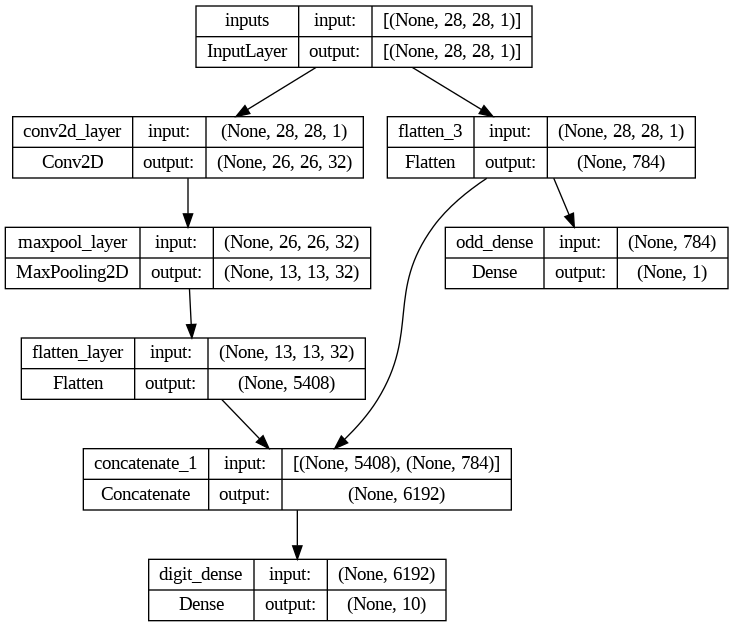

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

* 모델을 컴파일할 때 주의할 내용
  + 모델 정의할 때 각각의 출력 Dense 레이어에 name 속성으로 지정한 이름을 key로 하고, 해당 key에 해당하는 레이어에 적용할 손실함수와 가중치를 딕셔너리 형태로 지정
  + fit() 메소드 적용할 때도 출력 값 2개 지정. 레이어 이름 속성을 key로 하는 딕셔너리 형태로 각각의 출력에 맞는 정답 배열 입력

In [39]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss={'digit_dense': 'sparse_categorical_crossentropy',
                    'odd_dense':'binary_crossentropy'},
              loss_weights={'digit_dense':1, 'odd_dense':0.5},
              # loss = 1.0 * sparse_categorical_crossentropy + 0.5 * binary_crossentropy
              metrics=['accuracy'])

# 모델 훈련
history=model.fit({'inputs':x_train_in},
                  {'digit_dense':y_train, 'odd_dense':y_train_odd},
                   validation_data=({'inputs':x_valid_in}, {'digit_dense':y_valid, 'odd_dense':y_valid_odd}), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.3674 - digit_dense_loss: 0.2062 - odd_dense_loss: 0.3224 - digit_dense_accuracy: 0.9416 - odd_dense_accuracy: 0.8653 - val_loss: 0.2282 - val_digit_dense_loss: 0.0910 - val_odd_dense_loss: 0.2744 - val_digit_dense_accuracy: 0.9711 - val_odd_dense_accuracy: 0.8885
Epoch 2/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2168 - digit_dense_loss: 0.0811 - odd_dense_loss: 0.2715 - digit_dense_accuracy: 0.9765 - odd_dense_accuracy: 0.8909 - val_loss: 0.2090 - val_digit_dense_loss: 0.0781 - val_odd_dense_loss: 0.2619 - val_digit_dense_accuracy: 0.9750 - val_odd_dense_accuracy: 0.8952
Epoch 3/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1942 - digit_dense_loss: 0.0628 - odd_dense_loss: 0.2627 - digit_dense_accuracy: 0.9815 - odd_dense_accuracy: 0.8953 - val_loss: 0.1910 - val_digit_dense_loss: 0.0611 - val_odd_dense_loss: 0.2599 - val_digit_dense_accuracy: 0.9806 -

* 모델 성능 평가

In [40]:
# 모델 성능
model.evaluate({'inputs':x_valid_in}, {'digit_dense':y_valid, 'odd_dense':y_valid_odd})

313/313 [==============================] - 4s 11ms/step - loss: 0.1848 - digit_dense_loss: 0.0574 - odd_dense_loss: 0.2548 - digit_dense_accuracy: 0.9841 - odd_dense_accuracy: 0.9008


[0.18481279909610748,
 0.0574345700442791,
 0.25475630164146423,
 0.9840999841690063,
 0.9007999897003174]

* 검증 데이터셋의 인덱스 0에 해당하는 이미지 출력 -> 숫자 7에 대한 손글씨 이미지

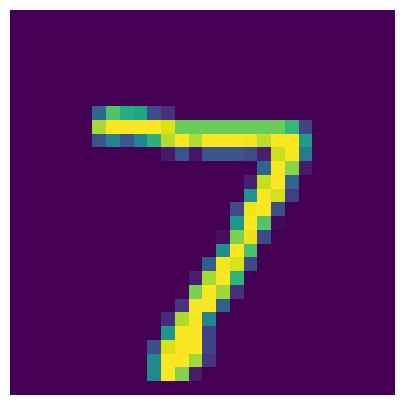

In [41]:
# 샘플 이미지 출력
import matplotlib.pylab as plt

def plot_image(data, idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx])
  plt.axis('off')
  plt.show()

plot_image(x_valid, 0)

* 검증 데이터셋의 모든 이미지 데이터 입력해 2개의 분류 문제에 대한 예측 확률 구하기
  + 첫 번째 예측 값은 10개 분류 레이블에 대한 확률. 두 번째 예측 값은 홀수일 확률

In [42]:
digit_preds, odd_preds=model.predict(x_valid_in)
print(digit_preds[0])
print(odd_preds[0])

313/313 [==============================] - 2s 6ms/step
[5.7999196e-11 9.3284958e-10 3.7085481e-09 1.0070301e-06 9.5995108e-11
 3.1258496e-12 3.8726492e-21 9.9999899e-01 5.7711023e-09 1.2588523e-08]
[0.999598]


* argmax 함수 이용해 예측 확률을 실제 정답 레이블로 변환

In [43]:
digit_labels=np.argmax(digit_preds, axis=1)
digit_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

* 홀수, 짝수 여부에 대한 예측 레이블 출력. 임계값으로 0.5 지정
  + 홀수일 확률이 0.5보다 큰 경우 홀수로 분류

In [45]:
odd_labels=(odd_preds>0.5).astype(np.int64).reshape(1, -1)[0]
odd_labels[0:10]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1])

### 3-4 전이 학습(Transfer Learning)

**Transfer Learning** : 앞서 훈련한 모델의 일부를 가져와서 그대로 사용하고, 최종 출력층만 새롭게 추가하여 모델 재구성하는 것, 즉 기존에 학습된 모델 활용해 새로운 모델 만들어 내는 개념

* 입력 레이어부터 'flatten_layer'라는 name 속성 갖는 Flatten 층까지 해당하는 부분 따로 추출하여, base_model 객체 만들기

In [46]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output=model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model=tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* 모델 구조 시각화

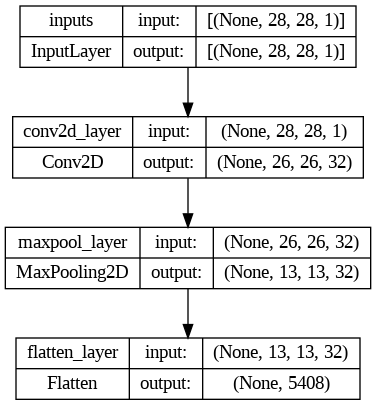

In [47]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

* Sequential API 사용하여 base_model 레이어로 추가, 최종 분류기 역할을 하는 Dense 레이어를 새롭게 이어서 추가

In [48]:
# Sequential API 적용
digit_model=tf.keras.Sequential([
    base_model, tf.keras.layers.Dense(10, activation='softmax')
])
digit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* 모델 구조 출력

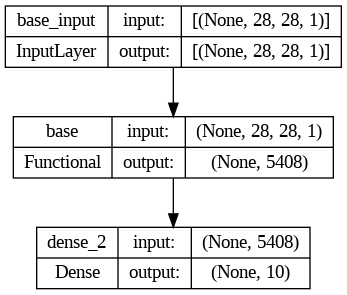

In [49]:
tf.keras.utils.plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

=> 최종적으로 노드 10개를 가진 분류기 역할을 하는 Dense 레이어 추가된 것 확인

* 모델 컴파일, 훈련

In [50]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=digit_model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1313 - accuracy: 0.9638 - val_loss: 0.0682 - val_accuracy: 0.9769
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0589 - accuracy: 0.9828 - val_loss: 0.0636 - val_accuracy: 0.9793
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0450 - accuracy: 0.9861 - val_loss: 0.0604 - val_accuracy: 0.9815
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0358 - accuracy: 0.9891 - val_loss: 0.0623 - val_accuracy: 0.9802
Epoch 5/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 0.0502 - val_accuracy: 0.9837
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0553 - val_accuracy: 0.9827
Epoch 7/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.0502 -

* 모델 인스턴스는 **trainable** 속성 가지고 있다
  + False로 지정하면 모델의 파라미터 값이 고정되어 훈련을 통해서 업데이트되지 않는다

In [51]:
# 베이스 모델의 가중치 고정 (Freeze Model)

base_model_frozen=tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen')
base_model_frozen.trainable=False
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


=> 훈련 가능한 파라미터 개수가 0으로 확인

* 파라미터 고정한 base_model_input 모델과 새로운 분류기 역할을 하는 Dense 레이어를 Functional API 적용하여 구성

In [52]:
# Functional API 적용
dense_output=tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen=tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54090 (211.29 KB)
Non-trainable params: 320 (1.25 KB)
_____________________

=> 총 파라미터 개수는 54410개. 고정한 320개의 파라미터는 훈련 불가능하다는 것 표시

훈련 가능한 파라미터는 Flatten 레이어의 출력 5408개와 Dense레이어의 10개 노드 사이의 가중치만 해당 -> Conv2D 레이어의 파라미터 320개는 포함되지 않게 된다는 뜻

* 모델 컴파일, 훈련

In [53]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=digit_model_frozen.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1174 - accuracy: 0.9677 - val_loss: 0.0537 - val_accuracy: 0.9827
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0492 - accuracy: 0.9854 - val_loss: 0.0531 - val_accuracy: 0.9844
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0356 - accuracy: 0.9890 - val_loss: 0.0500 - val_accuracy: 0.9833
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0273 - accuracy: 0.9918 - val_loss: 0.0500 - val_accuracy: 0.9844
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0215 - accuracy: 0.9937 - val_loss: 0.0529 - val_accuracy: 0.9841
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 0.0510 - val_accuracy: 0.9841
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0512 - val_ac

* 모델 전체가 아니라 특정 레이어를 지정하여 파라미터가 업데이트되지 않도록 고정하는 방법도 가능
  + Conv2D 레이어 취소, trainable 속성을 False로 지정

In [54]:
# 베이스 모델의 Conv2D 레이어의 가중치만 고정 (Freeze Layer)

base_model_frozen2=tf.keras.models.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable=False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


* 앞서 고정한 모델에 새로운 분류기 역할을 하는 Dense 레이어 연결하여 모델 구성

In [55]:
# Functional API 적용
dense_output2=tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen2.output)
digit_model_frozen2=tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54090 (211.29 KB)
Non-trainable params: 320 (1.25 KB)
_____________________

* 모델 컴파일, 훈련

In [56]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history=digit_model_frozen2.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1166 - accuracy: 0.9685 - val_loss: 0.0571 - val_accuracy: 0.9805
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0496 - accuracy: 0.9855 - val_loss: 0.0535 - val_accuracy: 0.9833
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0356 - accuracy: 0.9893 - val_loss: 0.0471 - val_accuracy: 0.9839
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0277 - accuracy: 0.9916 - val_loss: 0.0473 - val_accuracy: 0.9839
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 0.0513 - val_accuracy: 0.9842
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0179 - accuracy: 0.9945 - val_loss: 0.0506 - val_accuracy: 0.9833
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.0529 - val_ac